# Домашняя работа 6. Классификация.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.
4. Пришлите на почту ml-teachers ссылку на этот файл в вашем репозитории.
5. В теме письма указать `ML Homework #6: Name Surname`. Если тема будет неправильная, то задание не будет проверено.

**Дедлайн**: 4.12.2017 01:00 OMSK

    После дедлайна можно сдать, но вы получите штраф по баллам в рейтинге.

**Рассылка решений**: 9.12.2017 17:00 OMSK

    После рассылки задания совсем не имеют веса.

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)
- [Байесовский классификатор](http://www.machinelearning.ru/wiki/index.php?title=%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%82%D0%BE%D1%80)
- [Интересная статья про спам/не спам](https://habrahabr.ru/post/252265/)

Если вам понравилась задача распознавания текстов, то вот подборочка:

- [библиотека Gensim](https://radimrehurek.com/gensim/)
- [библиотека nltk](http://www.nltk.org/)
- [Лекция про word2vec 🔥](https://www.youtube.com/watch?v=oBb9aFmp0Hs)
- [Лекция Векторные представления слов и документов 🔥](https://www.youtube.com/watch?v=hiDBnEyoZS4)

В этой практике мы будем использовать алгоритмы k ближайших соседей и наивный байес для задач классификации и не только. 

## kNN - ближайшие соседи

Мы уже видели с вами на практиках и лекциях как применять алгоритм ближайших соседей. Мы даже видели с вами на примере классификации sms-спама, что этот метрический алгоритм не всегда справляется с многомерными данными. Поэтому в домашнем задании мы с вами сконцентриуемся на другой задаче, котоую можно решить этим алгоритмом: вы построите рекомендательную систему.

### Рекомендательная система

Будем использовать известный нам [датасет с оценками фильмов](http://www.cs.umn.edu/GroupLens). Только в этот раз мы не будем кластеризовывать жанры, а будем рекомендовать похожие фильмы, основываясь на оценках других пользователей. То есть мы будем по факту предсказывать предпочтение нового пользователя на основе других.

Для рекомендательной системы в датасете в объектами будут пользователи, а признаками - оценки фильма данным пользователем.

![](https://i.imgur.com/hn3xjZl.png)

Мы будем использовать метрический алгоритм для поиска ближайших соседей, тем самым рекомендовать фильмы близкие к данному.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
movies = pd.read_csv('../data/imdb_movies.csv.gz', index_col='movieId')
ratings = pd.read_csv('../data/imdb_ratings.csv.gz')

print(movies.shape)
print(ratings.shape)

(9125, 2)
(100004, 4)


In [3]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### 1.1 Поиск популярных фильмов (3 балла)

Среди всех фильмов есть не популярные, для которых выставлена 1-2 оценки. Такого количества данных не достаточно, поэтому нужно срезать много фильмов с маленьким числом отзывов.

Посчтитайте количество оценок для каждого фильма.

In [5]:
ratings_count = ratings.groupby('movieId')['rating'].agg(['count']).reset_index()
ratings_count.head()

,movieId,count
0,1,247
1,2,107
2,3,59
3,4,13
4,5,56


Выведите сводную статистику по количеству оценок фильмов. (общее число фильмов, среднее количество оценок, дисперсию, квантили)

In [6]:
ratings_count.describe()['count']

count    9066.000000
mean       11.030664
std        24.050800
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
Name: count, dtype: float64

Как мы видим `75%` квантиль показывет, что `75%` фильмов имело очень мало оценок. Нам столько будет недостаточно. Посчтитайте квантили в диапазоне от `75%` до `100%` с шагом в `1%`. Выберите тот квантиль, при котором количество оценок равно 20. Напишите какой это квантиль. Напишите сколько всего фильмов останется, если отбросить все фильмы у которых рейтинг меньше этого квантиля.

In [7]:
count_votes = 20
quantiles = np.arange(75 , 101, 1 , dtype=int)

for quantile in quantiles:
    c = ratings_count.quantile(round(quantile / 100 , 2))['count']
    if c == count_votes : 
        print("Выбираем кватниль {}% с количеством оценок: {} шт.".format(quantile , c))
        break

Выбираем кватниль 86% с количеством оценок: 20.0 шт.


In [8]:
seleced_movies = ratings_count[ratings_count['count'] > count_votes]
print("{} фильмов, у которых голосов больше {} шт.".format(seleced_movies.shape[0] , count_votes))

1247 фильмов, у которых голосов больше 20 шт.


### 1.2 Соединяем таблицы (1 балл)

Будет немного не удобно искать фильмы по их идентификаторам, нам нужны названия. Поэтому соедините две таблицы `ratings` и `movies` по `movieId` и отфильтруйте отзывы на редкие фильмы, которые мы нашли в предыдущем шаге. Выведите первые 5 элементов полученного датасета.

In [9]:
ratings_joined = ratings.join(movies , on='movieId')
ratings_joined = ratings_joined[ratings_joined['movieId'].isin(seleced_movies['movieId'])]
ratings_joined.head()

,userId,movieId,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


### 1.3 Матрица Фильмы-Пользователи

В нашем случае мы будем искать похожие фильмы, поэтому сделайте из датасета оценок матрицу, где в строках фильмы, в колонках пользователи, а в ячейках оценки. Пропущенные значение, то есть отсутсвие оценки, заполните 0.

Для увеличения скорости выполнения алгоритма ближайших соседей примените функцию [`scipy.sparse.csc_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html),  которая создаст плотное представление нашей разреженой матрицы.

In [10]:
rating_pivot = ratings_joined.pivot_table(index='title' , columns='userId' , values='rating').fillna(0)
rating_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Things I Hate About You (1999),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (One Hundred and One Dalmatians) (1961),0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
from scipy.sparse import csc_matrix

In [12]:
ratings_compressed = csc_matrix(rating_pivot)

### 1.4 Тренировка модели рекомендаций 

Так как по сути у нас нет каких-то меток классов, мы будем использовать алгоритма без учителя [`sklearn.neighbors.NearestNeighbors`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html). Научите его по данным нашей матрицы пользователей-фильмов и напишите **функцию**, принимающую на вход название фильма и возвращающую список из 6 рекомендованых фильмов, начиная от более похожего.

Для определения "похожести" двух фильмов мы будем использовать косинусную меру, вместо евклидова или минковского:

$$\LARGE cos(\overrightarrow{x},\overrightarrow{y}) = \frac{\overrightarrow{x} \cdot \overrightarrow{y}}{||\overrightarrow{x}|| \times ||\overrightarrow{y}||}$$

In [13]:
from sklearn.neighbors import NearestNeighbors

In [14]:
nearest = NearestNeighbors(metric='cosine')
nearest.fit(ratings_compressed)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [15]:
def similar(name='Pulp Fiction (1994)', n=6):
    # Тут какой-то код
    res = nearest.kneighbors([rating_pivot.loc[name]],n_neighbors=n+1 ,return_distance=True)
    df = pd.DataFrame(index=res[1][0], data=res[0][0]).sort_values(0)[1:]
    return pd.DataFrame(data=rating_pivot.index[df.index])
similar()

,title
0,"Silence of the Lambs, The (1991)"
1,"Shawshank Redemption, The (1994)"
2,Seven (a.k.a. Se7en) (1995)
3,Forrest Gump (1994)
4,"Usual Suspects, The (1995)"
5,Jurassic Park (1993)


Выведите рекомендации для фильмов:
- `Pulp Fiction (1994)`
- `Star Wars: Episode V - The Empire Strikes Back (1980)`
- `Lord of the Rings: The Two Towers, The (2002)`

In [16]:
similar('Pulp Fiction (1994)')

,title
0,"Silence of the Lambs, The (1991)"
1,"Shawshank Redemption, The (1994)"
2,Seven (a.k.a. Se7en) (1995)
3,Forrest Gump (1994)
4,"Usual Suspects, The (1995)"
5,Jurassic Park (1993)


In [17]:
similar('Star Wars: Episode IV - A New Hope (1977)')

,title
0,Star Wars: Episode V - The Empire Strikes Back...
1,Star Wars: Episode VI - Return of the Jedi (1983)
2,Raiders of the Lost Ark (Indiana Jones and the...
3,Back to the Future (1985)
4,"Matrix, The (1999)"
5,Indiana Jones and the Last Crusade (1989)


In [18]:
similar('Lord of the Rings: The Two Towers, The (2002)')

,title
0,"Lord of the Rings: The Return of the King, The..."
1,"Lord of the Rings: The Fellowship of the Ring,..."
2,Pirates of the Caribbean: The Curse of the Bla...
3,"Matrix, The (1999)"
4,Spider-Man (2002)
5,Shrek (2001)


### 1.5 Как посчитать качество рекомендации?

Как посчитать качество нашей классификации? У нас нет учителя, нет отложенной выборки. Мы просто посчитали все рейтинги и на основе них сделали предположения о похожести товаров. 

А как вы думаете можно проверить качество нашей рекомендательной системы? Напишите развернутый ответ своими словами.

#### Вариант 1
Чтобы оценить качество, симулировать тестирование на пользователях. Например выбрать пользователя(или даже набор пользователей). Возможно нужно упрощенный вариант делать - проголосовал / не оставил голоса.
Для тестового пользователя покажем 10 фильмов. Дальше будем оценивать отношение количество показанных рекомендаций к количеству реально оставленных отзывов к этим фильмам этим пользователем. Чем больше мы будем рекомендовать и попадать в число  
#### Вариант 2 - практический
Поскольку это сайт, есть еще вариант запустить сплит-тестирование. Главное выбрать правильный целевой показатель. Цель данной системы - увеличить вовлеченность пользователя на сайте. Например, количество просмотренных карточек фильма. Поэтому план такой запускаем тест СтараяСистемаРекомендаций vs НоваяСистема. Дожидаемся когда соберется количество данных достаточных чтобы сдлеать вывод о превосходстве одной над другой. 



## Наивный байесовский классификатор

На практике мы использовали его для детекции спам/не спам. В этот раз вы будете классифицировать [новостные тексты](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html). Попробуете разные методы  генерации признаков из текстов.

In [19]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

### 2.1 Загрузка данных (2 балла)

Мы будем использовать только 4 класса текстов: `'alt.atheism', 'sci.space', 'talk.religion.misc', 'comp.graphics'`.

Загрузите тренировочную и тестовую части датасета для этих категорий.

In [21]:
categories = ['alt.atheism' ,'sci.space', 'talk.religion.misc', 'comp.graphics' ]

In [23]:
news_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
news_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

Выведите по 1 тексту для каждой из категории.

In [86]:
for cat_index in np.arange(0 , len(news_train.target_names)) :
    print("Категория {}\n".format(news_train.target_names[cat_index]))
    #print("Data \"{}\"".format(news_train.data[np.where(news_train.target == cat_index)[0][0]]))
    print("Data:\n {} \n\n\n".format(news_train.data[np.where(news_train.target == cat_index)[0][0]]))

Категория alt.atheism

Data:
 I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me that Mr. Wingate hopes that the questions
will just go away, and he is doing his level best to change the
subject.  Given that this seems a rather common net.theist tactic, I
would like to suggest that we impress upon him our desire for answers,
in the following manner:

1. Ignore any future articles by Mr. Wingate that do not address the
Challenges, until he answers them or explictly announces that he
refuses to do so.

--or--

2. If you must respond to one of his articles, incl

### 2.2 Мешок слов

Начнем с самого простого способа извлечения признаков из текстов: обычный подсчет количества употреблений слов в тексте.

Для этого используем [sklearn.feature_extraction.text.CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Настройте его так, чтобы он использовал англиские стоп слова.

Проведите трансформаци текстов из обоих датасетов и выведите размер полученного словаря. (1 векторайзер для тестового и тренировочного датасета! У вас должны получиться матрицы с одинаковыми признаками-словами)

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

In [132]:
vectorizer = CountVectorizer(stop_words='english')

In [133]:
%time vectorizer.fit(np.concatenate((news_train.data, news_test.data)))

CPU times: user 1.37 s, sys: 480 ms, total: 1.85 s
Wall time: 1.86 s


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [134]:
print("Размер словаря {}" . format(len(vectorizer.vocabulary_)))

Размер словаря 33529


In [144]:
X_train = vectorizer.transform(news_train.data)
X_test =  vectorizer.transform(news_test.data)
y_train = news_train.target
y_test = news_test.target

In [143]:
X_train, X_test

(<2034x33529 sparse matrix of type '<class 'numpy.int64'>'
 	with 133634 stored elements in Compressed Sparse Row format>,
 <1353x33529 sparse matrix of type '<class 'numpy.int64'>'
 	with 94104 stored elements in Compressed Sparse Row format>)

In [145]:
y_train, y_test

(array([1, 3, 2, ..., 1, 0, 1]), array([2, 1, 1, ..., 3, 1, 1]))

Будем использовать классифиактор для мультиклассифкации [sklearn.naive_bayes.MultinomialNB]().

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [173]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



In [198]:
clf = MultinomialNB()

In [155]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=cv)
print("Accuracy: {}".format(scores.mean()))

Accuracy: 0.8254342083889075


In [156]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [160]:
y_pred = clf.predict(X_test).astype('int')

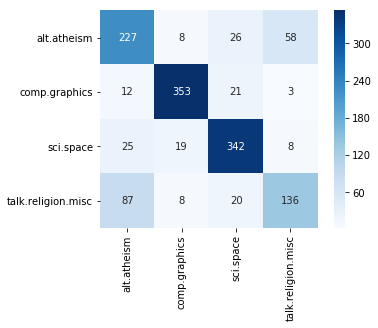

In [170]:
sns.heatmap(confusion_matrix(y_test, y_pred), 
            xticklabels=news_train.target_names, 
            yticklabels=news_train.target_names,
            cmap=plt.cm.Blues, 
            square=True, 
            annot=True, 
            fmt='.3g'
           )

In [174]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.65      0.71      0.68       319
          1       0.91      0.91      0.91       389
          2       0.84      0.87      0.85       394
          3       0.66      0.54      0.60       251

avg / total       0.78      0.78      0.78      1353



In [171]:
# Посмотрим на ТОП 10 по важности слова в каждой категории

def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("%s: [%s]" % (category, " ".join(feature_names[top10])))

show_top10(clf, vectorizer, news_train.target_names)

alt.atheism: [like believe say atheism does just think don people god]
comp.graphics: [software images files data use file jpeg edu graphics image]
sci.space: [just shuttle time orbit data like earth launch nasa space]
talk.religion.misc: [say know christian think just bible don jesus people god]


### 2.3 [Tf-IDF](https://ru.wikipedia.org/wiki/TF-IDF)

Мешок слов не учитывает "веса" слов, он просто смотрит их вхождение в документ. Вероятно, было бы полезно взвесить каким-то обраом каждое слово в документе. Действительно, если слово встречается во всех документах, то, наверное, его вес небольшой. А если редкое слово встречается в некоторых документах, то скорее всего оно какое-то узко тематическое.

Один из способов взвесить слова - это использовать меру tf-idf, где:

**TF - term frequency** - частота слова для каждой статьи

$$\LARGE \mathrm{tf}(t,d) = \frac{n_t}{\sum_k n_k}$$

**IDF - inverse document frequency*** — обратная частота документа - уменьшает вес часто встречаемых слов

$$\LARGE \mathrm{idf}(t, D) =  \log \frac{|D|}{|\{\,d_i \in D \mid t \in d_{i}\, \}|}$$

$D$ - число документов в корпусе

$|\{\,d_i \in D \mid t \in d_{i}\, \}|$ - число документов из коллекции ${\displaystyle D}$ , в которых встречается ${\displaystyle t}$  (когда ${\displaystyle n_{t}\neq 0}$ ).

**TF-IDF**

$$\LARGE \operatorname{tf-idf}(t,d,D) = \operatorname{tf}(t,d) \times \operatorname{idf}(t, D)$$


Для него есть класс [sklearn.feature_extraction.text.TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

- Проведите кроссвалидацию на 5 фолдах для метрики `accuracy`.
- обучите на тренировочных данных, 
- нарисуйте красивую confusion матрицу, (с именами классов, а не индексами по осям)
- выведите отчет классификации для тестовой выборки (с именами классов, а не индексами)

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [210]:
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_vec.fit(np.concatenate((news_train.data, news_test.data)))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [211]:
X_train = tfidf_vec.transform(news_train.data)
X_test = tfidf_vec.transform(news_test.data)

In [212]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_train, y_train, cv=cv)
print("Accuracy: {}".format(scores.mean()))

Accuracy: 0.7831698319325094


In [213]:
clf.fit(X_train , y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [214]:
y_pred = clf.predict(X_test)

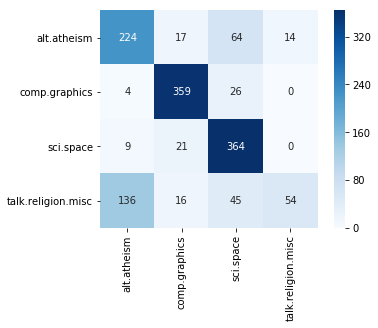

In [215]:
sns.heatmap(confusion_matrix(y_test, y_pred), 
            xticklabels=news_train.target_names, 
            yticklabels=news_train.target_names,
            cmap=plt.cm.Blues, 
            square=True, 
            annot=True, 
            fmt='.3g'
           )

In [216]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.60      0.70      0.65       319
          1       0.87      0.92      0.90       389
          2       0.73      0.92      0.82       394
          3       0.79      0.22      0.34       251

avg / total       0.75      0.74      0.71      1353



In [217]:
show_top10(clf, tfidf_vec, news_train.target_names)

alt.atheism: [islam does religion atheism say just think don people god]
comp.graphics: [does looking hi program know file image files thanks graphics]
sci.space: [lunar earth think orbit just moon launch like nasa space]
talk.religion.misc: [objective think just don bible christians christian people jesus god]


### 2.4 В чём проблема?

Как вы заметили, качество немного улучшилось. Как вы думаете почему у нас до сих пор есть ошибки? В чём проблема? Опирайтесь на вывод топа 10 важных слов, confusion matrix и репорт классификации.

**Задание**: Напишите развернутое рассуждение.

#### Ответ
Предположительная причина: В категориях "alt.atheism" и "talk.religion.misc" возникают холиварные споры на тему "докажи Бог есть/не существует" 
Большую ошибку вносит объекты из категории "talk.religion.misc". Полагаю, что в этой катогрии часто обсуждается Христианство, и очень редко ислам. Я думаю, что наш классификатор видя слово islam и religion, которые имеют большую вероятность встретиться в одном тексте, сразу относит этот текст к теме "alt.atheism". Это и порождает большое количество ошибок. Матрица ошибок это и показвыает, что наибольшее количество ошибок это признание текста talk.religion.misc за текст islam

![](https://i.imgur.com/3D5pgrk.png)

Можно еще немного улучшить качество предсказания, если использовть n-граммы, то есть не только одиночные слова, но и пары, тройки. Для этого у векторайзера есть параметр `ngram_range`, но будьте осторожны, сгенерируется очень много признаков. Их количество можно ограничить  `max_features`. Ещё можно копать в сторону правильного процессинга текстов: лемматизация и стемминг, чтобы убирать окончания, но это обчно не сильно помогает в английском языке.

Кроме того можно было бы пойти совсем в другую сторону и использовать word-2-vec технологии, тогда бы у нас слова начал "обретать" смысл. Но это вовсем другая история.